In [1]:
import os
os.listdir()

['.ipynb_checkpoints',
 'alphabet_classifier.pth',
 'car.jpg',
 'd2.jpg',
 'download.png',
 'image.jpg',
 'model_alpha.h5',
 'model_num.h5',
 'my_model.meta',
 'numbers',
 'numbers.zip',
 'number_classifier.pth',
 'Remote app.ipynb',
 'store',
 'test1.jpeg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpeg',
 'test7.png',
 'test8.JPG',
 'test9.jpg',
 'training and etc.ipynb',
 'Untitled.ipynb']

In [1]:
import cv2
import imutils
# import pytesseract
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import requests

def get_plate(img_path):
  # read the image and convert it to grayscale
  car = imread(img_path)
  #car = img_path
  gray_img=[]
  print(car.shape)
  if car.shape[2] == 3:
    gray_img = rgb2gray(car)
  else:
    gray_img = rgb2gray(rgba2rgb(car))

  #blur the image to remove any noise
  blurred_gray_img = gaussian(gray_img)

  thresh = threshold_otsu(gray_img)
  print(thresh)
  thresh = 0.46
  binary = invert(gray_img > thresh)
  label_image = label(binary, connectivity=2)  

  for region in regionprops(label_image):
      minr, minc, maxr, maxc = region.bbox
      rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
      


  text_like_regions = []
  for region in regionprops(label_image):
      minr, minc, maxr, maxc = region.bbox
      w = maxc - minc
      h = maxr - minr

      asr = w/h

      region_area = w*h

      wid,hei = blurred_gray_img.shape
      img_area = wid*hei

      # The aspect ratio is less than 1 to eliminate highly elongated regions
      # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
      # dimension to be considered for further processing
      if region_area > img_area/5000 and region_area < (0.2 * img_area) and asr < 1 and h > w:
          #print(w, h, i, region.area, region.bbox)
          text_like_regions.append(region)

  all_points = []
  for region in text_like_regions:
      minr, minc, maxr, maxc = region.bbox
      rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
      circ = mpatches.Circle((minc, minr), radius=5)
      all_points.append([minc, minr, maxc, maxr])

  # Define the threshold for ymin, ymax difference and area similarity
  y_threshold = 5  # Adjust this value as needed
  area_similarity_threshold = 0.5  # Adjust this value as needed

  # Sort the list of bounding boxes based on ymin (y-coordinate)
  sorted_boxes = sorted(all_points, key=lambda box: box[1])

  # Initialize variables
  groups = []
  current_group = []

  # Iterate over the sorted boxes
  for box in sorted_boxes:
      if not current_group:
          current_group.append(box)
      else:
          prev_box = current_group[-1]
          ymin_diff = abs(box[1] - prev_box[1])
          ymax_diff = abs(box[3] - prev_box[3])
          #area_similarity = abs((box[2] - box[0]) * (box[3] - box[1]) - (prev_box[2] - prev_box[0]) * (prev_box[3] - prev_box[1]))

          if ymin_diff <= y_threshold and ymax_diff <= y_threshold :
              current_group.append(box)
          else:
              if len(current_group) >= 10:
                  groups.append(current_group[:10])  # Extract the first 10 bounding boxes
              current_group = [box]

  # Check if the last group satisfies the condition
  if len(current_group) >= 10:
      groups.append(current_group[:10])  # Extract the first 10 bounding boxes

  groups = sorted(groups[0], key=lambda box: box[0])


  alpha = load_model('model_alpha.h5', compile=False)
  num = load_model('model_num.h5', compile=False)
  predictions = []
  # Load the image containing the license plate
  image_path = img_path
  image = cv2.imread(image_path)

  # Define the license plate coordinates
  license_plate_coords = groups

  # Perform OCR on each license plate coordinate
  for index, coords in enumerate(license_plate_coords):
      # Crop the license plate region
      xmin, ymin, xmax, ymax = coords
      license_plate = image[ymin:ymax, xmin:xmax]
      license_plate = cv2.resize(license_plate, (128, 128))
      # Preprocess the image
      #x = preprocess_input(license_plate)
      # Add an extra dimension to represent the batch size
      x = np.expand_dims(license_plate, axis=0)

      if index in [0, 1, 4, 5]:
        prediction = np.argmax(alpha.predict(x))
        predictions.append(chr(ord('A') + prediction))
      else:
        prediction = np.argmax(num.predict(x))
        predictions.append(prediction)

  string_array = [str(item) for item in predictions]
  return "".join(string_array)

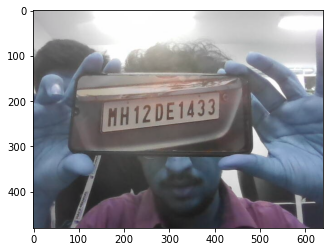

(480, 640, 3)
0.5632582720588235
MH12DE1433
<Response [200]>
Request successful!


KeyboardInterrupt: 

In [4]:
import cv2
from datetime import datetime
import time
import sched
import os
# import tensorflow as tf
import requests


def predict_string(image):
    return "AB12CD4567"
def check_consistency(text, length):
    return len(text) == length

# Load the machine learning model from .h5 file
# model = tf.keras.models.load_model('model.h5')

# Create a scheduler
scheduler = sched.scheduler(time.time, time.sleep)

# Define constants
CONSISTENT_OUTPUT_THRESHOLD = 3
API_ENDPOINT = "http://example.com/api"
license_id="vv71vv7111"
i = 0


# Function to capture image, generate string prediction, and make API call
def capture_predict_and_call_api(sc):
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"image.jpg"
    
    cv2.imwrite(filename, frame)
    image = cv2.imread(filename)
    #
    prediction = ""
    
    plt.imshow(image, cmap="gray")
    plt.show()
    
    try:
        prediction = get_plate(filename)
        print("MH12DE1433")
    except:
        prediction = ""
        print("No Number Plate Found")
        
    consistent = check_consistency(prediction, 10)
    

    
    if consistent or i==3:
        # response = requests.post(API_ENDPOINT, json=api_data)
        # print(response.text)
        url = 'http://localhost:6969/bookings/accept/'
        payload = {
            "garageId": "64ab9dd4ef75ee5dfc77f383",
            "licenseId": license_id
        }
        
        i=0
        

        response = requests.post(url, json=payload)
        
        print(response)

        if response.status_code == 200:
            print("Request successful!")
    # Handle the response data here if needed
    else:
        print("Request failed")
        i+=1
    time.sleep(5)

    # Schedule the next capture and prediction
    scheduler.enter(1, 1, capture_predict_and_call_api, (sc,))

# Start the scheduler
scheduler.enter(1, 1, capture_predict_and_call_api, (scheduler,))
scheduler.run()